In [32]:
import os
import sys


sys.path.append(os.path.abspath(os.path.join(os.path.dirname("__file__"), "src")))

In [40]:
import torch


env_name = "box-close-v2"
# env_name = "button-press-topdown-v2"
exp_name = "AESPA-17"
pair_algo = "ternary-500"
reward_model_algo = "MR-linear"

os.environ["CUDA_VISIBLE_DEVICES"] = "2" 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

TRAJECTORY_LENGTH = 25

In [34]:
import glob

import numpy as np
from data_loading.load_data import load_dataset
from reward_learning.get_model import get_reward_model
from utils.path import get_reward_model_path

def predict_rewards(
    env_name,
    exp_name,
    pair_algo,
    reward_model_algo,
):
    dataset = load_dataset(env_name)
    obs_dim = dataset["observations"].shape[1]
    act_dim = dataset["actions"].shape[1]

    print("obs_dim:", obs_dim, "act_dim:", act_dim)
    model_path_pattern = get_reward_model_path(
        env_name=env_name,
        exp_name=exp_name,
        pair_algo=pair_algo,
        reward_model_algo=reward_model_algo,
        reward_model_tag="*",
    )
    model_files = glob.glob(model_path_pattern)
    model_list = []

    for model_file in model_files:
        model, _ = get_reward_model(
            reward_model_algo=reward_model_algo,
            obs_dim=obs_dim,
            act_dim=act_dim,
            model_path=model_file,
            allow_existing=True,
        )
        model_list.append(model)

    dataset = load_dataset(env_name)

    num_samples = len(dataset["observations"])
    batch_size = num_samples // 20
    model_outputs = []

    for start_idx in range(0, num_samples, batch_size):
        end_idx = min(start_idx + batch_size, num_samples)

        obs_batch = torch.tensor(
            dataset["observations"][start_idx:end_idx], dtype=torch.float32
        ).to(device)
        act_batch = torch.tensor(
            dataset["actions"][start_idx:end_idx], dtype=torch.float32
        ).to(device)

        batch_model_outputs = []
        for model in model_list:
            rewards = model.batched_forward_trajectory(
                obs_batch=obs_batch, act_batch=act_batch
            )
            batch_model_outputs.append(rewards.detach().cpu().numpy())

        batch_predicted_rewards = np.mean(batch_model_outputs, axis=0)
        model_outputs.append(batch_predicted_rewards)

    predicted_rewards = np.concatenate(model_outputs, axis=0).squeeze()

    return predicted_rewards


In [35]:
def fill_feedback_from_raw_dataset(average_reward, cumulative_rewards, pairs):
    """
    Fill feedback in dataset using cumulative rewards and calculate mu values.
    """

    feedbacks = []

    for s0, s1 in pairs:
        sum_of_rewards_0 = cumulative_rewards[s0[1] - 1] - (
            cumulative_rewards[s0[0] - 1] if s0[0] > 0 else 0
        )
        sum_of_rewards_1 = cumulative_rewards[s1[1] - 1] - (
            cumulative_rewards[s1[0] - 1] if s1[0] > 0 else 0
        )

        if (
            np.abs(sum_of_rewards_0 - sum_of_rewards_1)
            < average_reward * TRAJECTORY_LENGTH * 0.1
        ):
            mu = 0.5
        else:
            mu = 0 if sum_of_rewards_0 > sum_of_rewards_1 else 1

        feedbacks.append((s0, s1, mu))

    return feedbacks


In [36]:
import numpy as np
from data_generation.utils import save_feedbacks_npz
from data_loading.load_data import load_pair

feedback_count_to_add = 500

raw_dataset = load_dataset(env_name)
average_reward = np.mean(raw_dataset["rewards"])
cumulative_rewards = np.cumsum(raw_dataset["rewards"])

for i in range(10):
    exp_name_with_suffix = f"{exp_name}-{i:02d}"
    predicted_rewards = predict_rewards(
        env_name=env_name,
        exp_name=exp_name_with_suffix,
        pair_algo=pair_algo,
        reward_model_algo=reward_model_algo,
    )

    predicted_rewards = np.array(predicted_rewards)
    predicted_cumsum = np.cumsum(predicted_rewards)

    train_all_pairs_with_mu = load_pair(
        env_name=env_name,
        exp_name=exp_name_with_suffix,
        pair_type="train_all",
        pair_algo="raw",
    )

    all_traj_set = []
    for p in train_all_pairs_with_mu:
        all_traj_set.append(p[0])
        all_traj_set.append(p[1])

    # ✅ sub_traj + 원본 traj 인덱스 저장
    traj_with_reward = []
    for traj_idx, traj in enumerate(all_traj_set):
        for start in range(traj[0], traj[1] - TRAJECTORY_LENGTH + 1):
            traj_start = start
            traj_end = start + TRAJECTORY_LENGTH

            reward_sum = predicted_cumsum[traj_end - 1] - (
                predicted_cumsum[traj_start - 1] if traj_start > 0 else 0
            )
            sub_traj = (traj_start, traj_end)
            traj_with_reward.append((sub_traj, reward_sum, traj_idx))   

    # ✅ reward 기준 내림차순 정렬
    traj_with_reward.sort(key=lambda x: x[1], reverse=True)

    # ✅ 인접한 것들 중 source_idx가 다르면 pair로 추가
    k = 0
    pairs = []
    while k < len(traj_with_reward) - 1:
        traj1, _, idx1 = traj_with_reward[k]
        traj2, _, idx2 = traj_with_reward[k + 1]

        if idx1 != idx2:
            pairs.append((traj1, traj2))
            k += 2  
        else:
            k += 1 

        if len(pairs) >= feedback_count_to_add:
            break
    
    feedbacks = fill_feedback_from_raw_dataset(
        average_reward=average_reward,
        cumulative_rewards=cumulative_rewards,
        pairs=pairs,
    )

    count_0 = 0
    count_0_5 = 0
    count_1 = 0

    for _, _, mu in feedbacks:
        if mu == 0:
            count_0 += 1
        elif mu == 0.5:
            count_0_5 += 1
        elif mu == 1:
            count_1 += 1

    print(
        f"Feedbacks: {len(feedbacks)}, 0: {count_0}, 0.5: {count_0_5}, 1: {count_1}"
    )

    ternary_feedback = load_pair(
        env_name=env_name,
        exp_name=exp_name_with_suffix,
        pair_type="train",
        pair_algo=pair_algo,
    ).tolist()

    print(len(ternary_feedback+feedbacks))

    save_feedbacks_npz(
        env_name=env_name,
        exp_name=exp_name_with_suffix,
        feedbacks=ternary_feedback + feedbacks,
        pair_type="train",
        pair_name=f"{pair_algo}-augmented",
    )
  
    

obs_dim: 39 act_dim: 4
Model loaded from model/button-press-topdown-v2/AESPA-17-00/reward/ternary-500/MR-linear_02.pth
Model loaded from model/button-press-topdown-v2/AESPA-17-00/reward/ternary-500/MR-linear_06.pth
Model loaded from model/button-press-topdown-v2/AESPA-17-00/reward/ternary-500/MR-linear_01.pth
Model loaded from model/button-press-topdown-v2/AESPA-17-00/reward/ternary-500/MR-linear_00.pth
Model loaded from model/button-press-topdown-v2/AESPA-17-00/reward/ternary-500/MR-linear_05.pth
Model loaded from model/button-press-topdown-v2/AESPA-17-00/reward/ternary-500/MR-linear_03.pth
Model loaded from model/button-press-topdown-v2/AESPA-17-00/reward/ternary-500/MR-linear_04.pth
Feedbacks: 500, 0: 228, 0.5: 57, 1: 215
1000
Saved feedbacks at pair/button-press-topdown-v2/AESPA-17-00/train/ternary-500-augmented.npz
obs_dim: 39 act_dim: 4
Model loaded from model/button-press-topdown-v2/AESPA-17-01/reward/ternary-500/MR-linear_02.pth
Model loaded from model/button-press-topdown-v2/A

obs_dim: 39 act_dim: 4
Model loaded from model/box-close-v2/AESPA-17-00/reward/ternary-500-augmented/MR-linear_02.pth
Model loaded from model/box-close-v2/AESPA-17-00/reward/ternary-500-augmented/MR-linear_06.pth
Model loaded from model/box-close-v2/AESPA-17-00/reward/ternary-500-augmented/MR-linear_01.pth
Model loaded from model/box-close-v2/AESPA-17-00/reward/ternary-500-augmented/MR-linear_00.pth
Model loaded from model/box-close-v2/AESPA-17-00/reward/ternary-500-augmented/MR-linear_05.pth
Model loaded from model/box-close-v2/AESPA-17-00/reward/ternary-500-augmented/MR-linear_03.pth
Model loaded from model/box-close-v2/AESPA-17-00/reward/ternary-500-augmented/MR-linear_04.pth


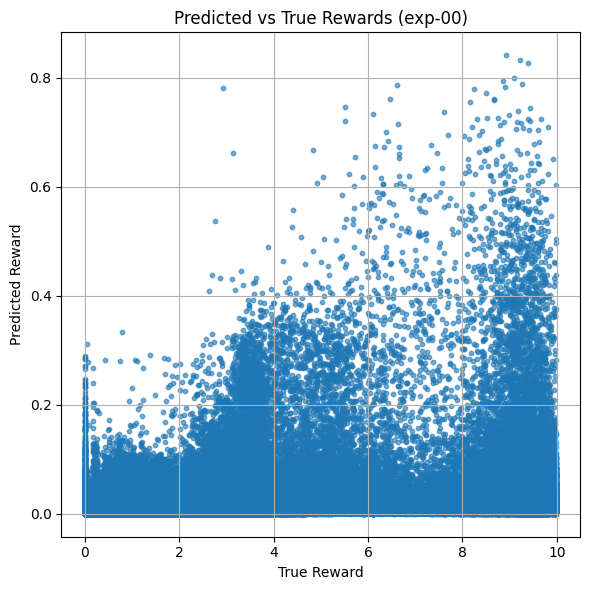

[exp-00]
  PCC (Pearson Correlation): 0.2887
  Order Agreement (100000 pairs): 0.7155

obs_dim: 39 act_dim: 4
Model loaded from model/box-close-v2/AESPA-17-01/reward/ternary-500-augmented/MR-linear_02.pth
Model loaded from model/box-close-v2/AESPA-17-01/reward/ternary-500-augmented/MR-linear_06.pth
Model loaded from model/box-close-v2/AESPA-17-01/reward/ternary-500-augmented/MR-linear_01.pth
Model loaded from model/box-close-v2/AESPA-17-01/reward/ternary-500-augmented/MR-linear_00.pth
Model loaded from model/box-close-v2/AESPA-17-01/reward/ternary-500-augmented/MR-linear_05.pth
Model loaded from model/box-close-v2/AESPA-17-01/reward/ternary-500-augmented/MR-linear_03.pth
Model loaded from model/box-close-v2/AESPA-17-01/reward/ternary-500-augmented/MR-linear_04.pth


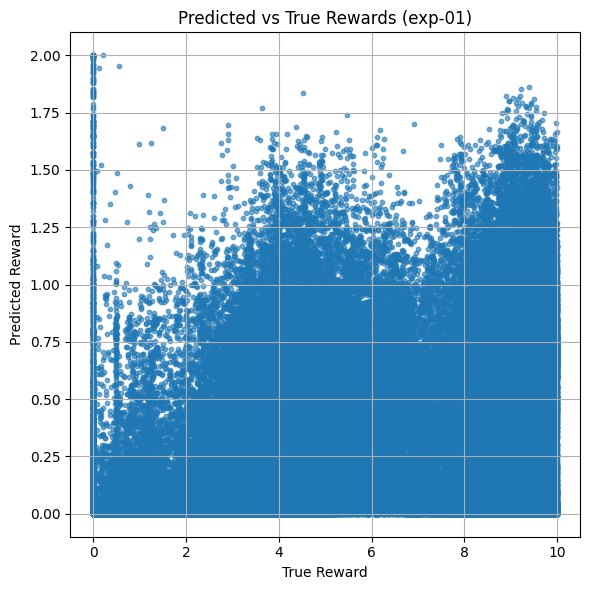

[exp-01]
  PCC (Pearson Correlation): 0.6472
  Order Agreement (100000 pairs): 0.7905

obs_dim: 39 act_dim: 4
Model loaded from model/box-close-v2/AESPA-17-02/reward/ternary-500-augmented/MR-linear_02.pth
Model loaded from model/box-close-v2/AESPA-17-02/reward/ternary-500-augmented/MR-linear_06.pth
Model loaded from model/box-close-v2/AESPA-17-02/reward/ternary-500-augmented/MR-linear_01.pth
Model loaded from model/box-close-v2/AESPA-17-02/reward/ternary-500-augmented/MR-linear_00.pth
Model loaded from model/box-close-v2/AESPA-17-02/reward/ternary-500-augmented/MR-linear_05.pth
Model loaded from model/box-close-v2/AESPA-17-02/reward/ternary-500-augmented/MR-linear_03.pth
Model loaded from model/box-close-v2/AESPA-17-02/reward/ternary-500-augmented/MR-linear_04.pth


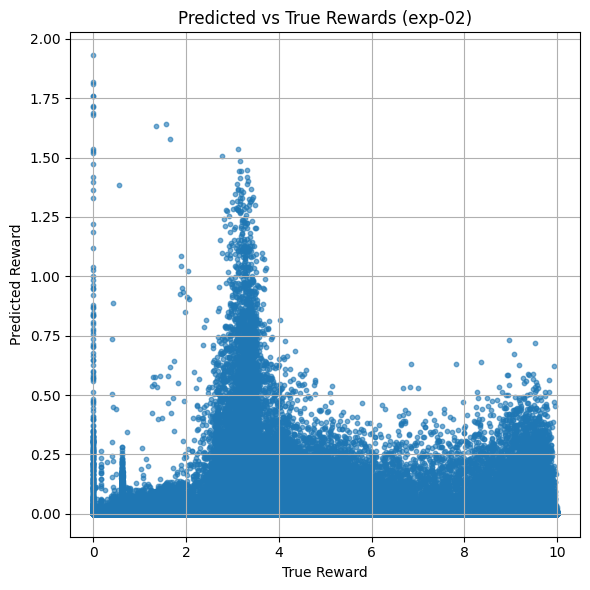

[exp-02]
  PCC (Pearson Correlation): 0.1563
  Order Agreement (100000 pairs): 0.8262

Overall Results:
  Average PCC: 0.3641 ± 0.2074
  Average Order Agreement: 0.7774 ± 0.0461


In [43]:
import numpy as np
import matplotlib.pyplot as plt
import random

dataset = load_dataset(env_name)

pcc_list = []
order_agreement_list = []

for i in range(3):
    predicted_rewards = predict_rewards(
        env_name=env_name,
        exp_name=f"{exp_name}-{i:02d}",
        pair_algo="ternary-500-augmented",
        reward_model_algo=reward_model_algo,
    )

    true_rewards = dataset["rewards"]

    # ⬇️ numpy array로 변환 + flatten 해서 PCC 계산 오류 방지
    true_rewards = np.array(true_rewards).flatten()
    predicted_rewards = np.array(predicted_rewards).flatten()

    # 📊 산점도 그리기 (y = x 생략)
    plt.figure(figsize=(6, 6))
    plt.scatter(true_rewards, predicted_rewards, alpha=0.6, s=10, label="Samples")
    plt.xlabel("True Reward")
    plt.ylabel("Predicted Reward")
    plt.title(f"Predicted vs True Rewards (exp-{i:02d})")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # ✅ PCC 계산 (np.corrcoef)
    try:
        pcc = np.corrcoef(true_rewards, predicted_rewards)[0, 1]
    except Exception as e:
        print(f"[exp-{i:02d}] PCC 계산 중 오류 발생: {e}")
        pcc = float('nan')

    # ✅ 대소관계 일치도 계산 (샘플링 기반)
    num_samples = 100000
    agree = 0
    n = len(true_rewards)

    for _ in range(num_samples):
        i1, i2 = random.sample(range(n), 2)
        gt_diff = true_rewards[i1] - true_rewards[i2]
        pred_diff = predicted_rewards[i1] - predicted_rewards[i2]

        if gt_diff * pred_diff > 0 or (gt_diff == 0 and pred_diff == 0):
            agree += 1

    order_agreement = agree / num_samples

    # ✅ 결과 저장
    pcc_list.append(pcc)
    order_agreement_list.append(order_agreement)

    # ✅ 결과 출력
    print(f"[exp-{i:02d}]")
    print(f"  PCC (Pearson Correlation): {pcc:.4f}")
    print(f"  Order Agreement ({num_samples} pairs): {order_agreement:.4f}")
    print()

# ✅ 전체 결과 출력
print("Overall Results:")
print(f"  Average PCC: {np.nanmean(pcc_list):.4f} ± {np.nanstd(pcc_list):.4f}")
print(f"  Average Order Agreement: {np.mean(order_agreement_list):.4f} ± {np.std(order_agreement_list):.4f}")